# projeto7



In [1]:
import time
import cv2
import cv2.aruco as A
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def plot_image(img, figsize=(12,12), axis='off'):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis(axis)
    plt.show()

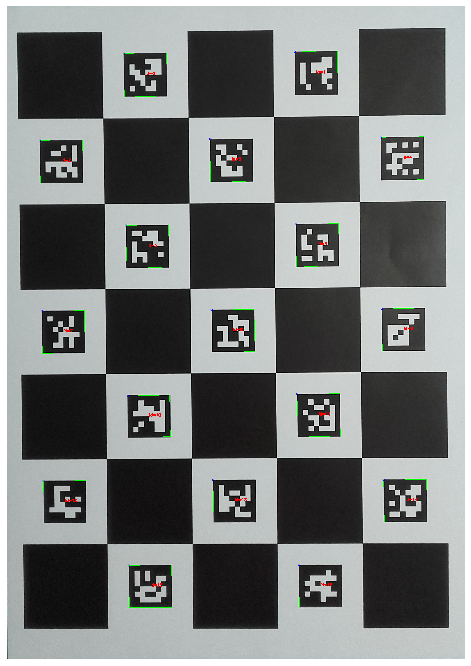

In [3]:
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_50)
board = cv2.aruco.CharucoBoard_create(3,3,.025,.0125,dictionary)

img_ref = cv2.imread("ref_origin.png")

ref_points = cv2.aruco.detectMarkers(img_ref,dictionary)
cv2.aruco.drawDetectedMarkers(img_ref,ref_points[0],ref_points[1])
ref_corners = cv2.aruco.interpolateCornersCharuco(ref_points[0],ref_points[1],img_ref,board)
plot_image(img_ref)


In [4]:
def plot_on_board(superfice,res,frame,ref_corners):
    ref_point = []
    point = []
    index = []
    corners = cv2.aruco.interpolateCornersCharuco(res[0],res[1],frame,board)

    for i in range(len(corners[2])):
        #i = corners[2]
        for j in range(len(ref_corners[2])):
            #j+=i if (j+i < len(ref_corners[2])
            if(corners[2][i][0] == (ref_corners[2][j][0])): # point mach
                point.append(corners[1][i][0])
                ref_point.append(ref_corners[1][j][0])
                index.append(j)

    homography = cv2.findHomography(np.array(ref_point), np.array(point))

    h, w, _ = frame.shape
    warped = cv2.warpPerspective(superfice, homography[0], (w, h))


    imagem_final = cv2.addWeighted(warped, 1, frame, 1, 0)
    return imagem_final

In [5]:
#Start capturing images for calibration
cap = cv2.VideoCapture(0)

allCorners = []
allIds = []
decimator = 0

superfice = cv2.imread("nier.png")
superfice = cv2.resize(superfice, (img_ref.shape[1], img_ref.shape[0]))
while True:

    ret,frame = cap.read()
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    res = cv2.aruco.detectMarkers(frame,dictionary)
    try:
        if len(res[0])>=5:
            cv2.aruco.drawDetectedMarkers(frame,res[0],res[1])
            frame = plot_on_board(superfice,res,frame,ref_corners)
    except:
        pass
        
        '''
        res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board))
        if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%3==0:
            allCorners.append(res2[1])
            allIds.append(res2[2])

        
        lala = cv2.aruco.drawDetectedCornersCharuco(gray, res2[1])
        '''

    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    decimator+=1
    
#gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#imsize = gray.shape

#Calibration fails for lots of reasons. Release the video if we do
"""
try:
    cal = cv2.aruco.calibrateCameraCharuco(allCorners,allIds,board,imsize,None,None)
except:
    cap.release()
"""

cap.release()
cv2.destroyAllWindows()

In [6]:
cap.release()
cv2.destroyAllWindows()